<a href="https://colab.research.google.com/github/nickwan/michelin-star-predictor/blob/main/22_04_14_blitz_michelin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import os 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [29]:
project_dir = "drive/My Drive/michelinstar"
df = pd.read_csv(f"{project_dir}/michelin_my_maps.csv")
_df = df['Cuisine'].str.split(',', expand=True).rename(columns={0: 'food1',1:'food2'})
df['food1'] = ''
df['food2'] = ''
df.loc[:, ['food1','food2']] = _df
x = df['food1'].append(df['food2'])
y = x.astype('category').cat.codes

z = pd.DataFrame()
z['food'] = x
z['food_code'] = y
z = z.drop_duplicates()
df['Currency_code'] = df['Currency'].astype('category').cat.codes
df = df.merge(z.rename(columns={'food':'food1', 'food_code':'food_code1'}))
df = df.merge(z.rename(columns={'food':'food2', 'food_code':'food_code2'}))
for col in ['MinPrice', 'MaxPrice']:
  df[col] = df[col].str.replace(',','').astype(float)
df['stars'] = df['Award'].replace(['3 MICHELIN Stars', '2 MICHELIN Stars', '1 MICHELIN Star',
       'Bib Gourmand'], [3,2,1,0])  
df.shape

(6502, 19)

In [30]:
df.head()

,Name,Address,Location,MinPrice,MaxPrice,Currency,Cuisine,Longitude,Latitude,PhoneNumber,Url,WebsiteUrl,Award,food1,food2,Currency_code,food_code1,food_code2,stars
0,Aqua,"Parkstraße 1, Wolfsburg, 38440, Germany",Wolfsburg,225.0,225.0,EUR,"Creative, Modern Cuisine",10.789999,52.433172,4.953616e+11,https://guide.michelin.com/en/niedersachsen/wo...,http://www.restaurant-aqua.com,3 MICHELIN Stars,Creative,Modern Cuisine,5,170,74,3
1,Piazza Duomo,"vicolo dell'Arco 1, angolo piazza Risorgimento...",Alba,270.0,300.0,EUR,"Creative, Modern Cuisine",8.035934,44.700556,3.901734e+11,https://guide.michelin.com/en/piemonte/alba/re...,https://www.piazzaduomoalba.it/,3 MICHELIN Stars,Creative,Modern Cuisine,5,170,74,3
2,La Vague d'Or - Cheval Blanc St-Tropez,"Plage de la Bouillabaisse, Saint-Tropez, 83990...",Saint-Tropez,310.0,375.0,EUR,"Creative, Modern Cuisine",6.626154,43.266585,3.349456e+10,https://guide.michelin.com/en/provence-alpes-c...,https://www.chevalblanc.com/,3 MICHELIN Stars,Creative,Modern Cuisine,5,170,74,3
3,Le 1947 - Cheval Blanc,"Le Jardin Alpin, Courchevel 1850, Courchevel, ...",Courchevel,355.0,395.0,EUR,"Creative, Modern Cuisine",6.633870,45.409488,3.347901e+10,https://guide.michelin.com/en/auvergne-rhone-a...,https://www.chevalblanc.com/courchevel,3 MICHELIN Stars,Creative,Modern Cuisine,5,170,74,3
4,Le Pré Catelan,"Route de Suresnes - bois de Boulogne, Paris, 7...",Paris,150.0,330.0,EUR,"Creative, Modern Cuisine",2.250718,48.863937,3.314414e+10,https://guide.michelin.com/en/ile-de-france/pa...,http://www.precatelanparis.com/,3 MICHELIN Stars,Creative,Modern Cuisine,5,170,74,3


In [31]:
df.columns.values

array(['Name', 'Address', 'Location', 'MinPrice', 'MaxPrice', 'Currency',
       'Cuisine', 'Longitude', 'Latitude', 'PhoneNumber', 'Url',
       'WebsiteUrl', 'Award', 'food1', 'food2', 'Currency_code',
       'food_code1', 'food_code2', 'stars'], dtype=object)

In [32]:
feats = ['MinPrice', 'MaxPrice','food_code1',
         'food_code2', 'Currency_code', 
         'Longitude', 'Latitude' ]
target = 'stars'

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from scipy.stats import pearsonr

In [34]:
model_data = df.dropna(subset=feats+[target])

kf = KFold(3)
s = pd.Series()
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]
  model = RandomForestRegressor()
  model.fit(train_data.loc[:, feats], train_data[target])
  s = s.append(pd.Series(model.predict(test_data.loc[:, feats]), index=test_data.index))
model_data['pred'] = s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


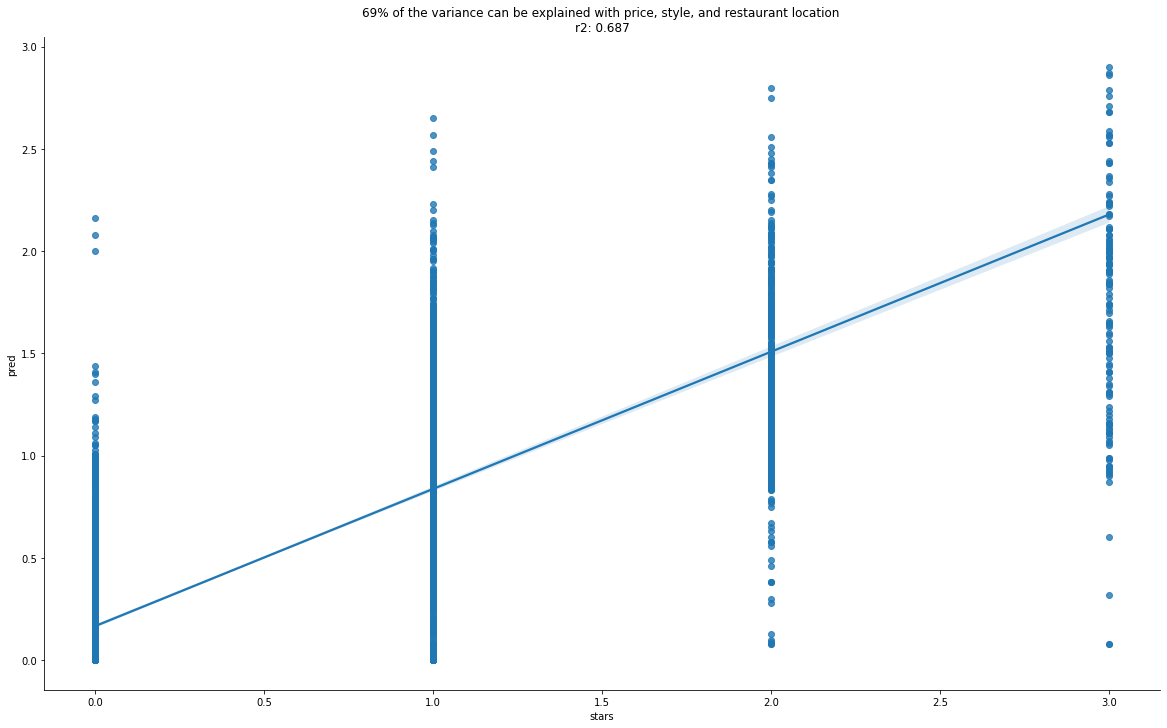

In [39]:
r2 = pearsonr(model_data[target], model_data['pred'])[0]**2
fig = plt.figure(figsize=(20,12))
sns.regplot(data=model_data, x=target, y='pred')
plt.title(f"69% of the variance can be explained with price, style, and restaurant location \nr2: {round(r2, 3)}")
sns.despine()
plt.show()

In [42]:
model_data['stars_over_expected'] = model_data[target].sub(model_data['pred'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [44]:
model_data.columns.values

array(['Name', 'Address', 'Location', 'MinPrice', 'MaxPrice', 'Currency',
       'Cuisine', 'Longitude', 'Latitude', 'PhoneNumber', 'Url',
       'WebsiteUrl', 'Award', 'food1', 'food2', 'Currency_code',
       'food_code1', 'food_code2', 'stars', 'pred', 'stars_over_expected'],
      dtype=object)

In [47]:
show_feats = ['Name', 'Address', 'Location', 'MinPrice', 'MaxPrice', 'Currency','stars','stars_over_expected']
model_data.loc[:, show_feats].sort_values('stars_over_expected', ascending=False).head(10)

,Name,Address,Location,MinPrice,MaxPrice,Currency,stars,stars_over_expected
2761,Gaon,"M Floor Horim Art Center, 317 Dosan-daero, Gan...",SEOUL,130000.0,260000.0,KRW,3,2.92
2762,La Yeon,"23F Shilla Hotel, 249 Dongho-ro, Jung-gu, SEOU...",SEOUL,109000.0,280000.0,KRW,3,2.92
2213,8 1/2 Otto e Mezzo - Bombana,"18 Chater Road, Hong Kong",Hong Kong,700.0,2080.0,HKD,3,2.68
2344,Sushi Shikon,"15 Queen's Road Central, Hong Kong",Hong Kong,2000.0,3500.0,HKD,3,2.40
2497,Isshisoden Nakamura,"136 Matsushitacho, Nakagyo-ku, Kyoto, 604-8093...",Kyoto,26000.0,38000.0,JPY,3,2.13
2496,Taian,"1-21-2 Shimanochi, Chuo-ku, Osaka, 542-0082, J...",Osaka,20000.0,20000.0,JPY,3,2.10
2499,Gion Sasaki,"566-27 Komatsucho, Higashiyama-ku, Kyoto, 605-...",Kyoto,8000.0,37000.0,JPY,3,2.09
2495,Kashiwaya,"2-5-18 Senriyamanishi, Suita, Osaka, 565-0851,...",Osaka,13000.0,43000.0,JPY,3,2.08
2501,Hyotei,"35 Nanzenji-kusagawacho, Sakyo-ku, Kyoto, 606-...",Kyoto,26000.0,64000.0,JPY,3,2.07
2498,Kikunoi Honten,"459 Shimokawaracho, Higashiyama-ku, Kyoto, 605...",Kyoto,17000.0,64000.0,JPY,3,2.06


In [48]:
model_data.loc[:, show_feats].sort_values('stars_over_expected', ascending=False).tail(10)

,Name,Address,Location,MinPrice,MaxPrice,Currency,stars,stars_over_expected
2448,S.B.L.,"710-714 Maha Chai Road, Wang Burapha Phirom, B...",Bangkok,1200.0,1200.0,THB,0,-1.41
2542,Endo at The Rotunda,"The Helios, 101 Wood Lane, London, W12 7FR, Un...",London,195.0,195.0,GBP,1,-1.41
2948,Surf & Turf by Soul Kitchen,"115 Phang Nga Road, Talad Yai, Phuket, 83000, ...",Phuket,1500.0,1500.0,THB,0,-1.44
2225,Mio,"48 Liangmaqiao Road, Beijing, China Mainland",Beijing,298.0,1688.0,CNY,1,-1.44
4450,Nikunotakumi Miyoshi,"570-15 Gionmachi-minamigawa, Higashiyama-ku, K...",Kyoto,48000.0,48000.0,JPY,1,-1.49
2224,Il Ristorante - Niko Romito,"Xinyuan South Road, Beijing, China Mainland",Beijing,458.0,1900.0,CNY,1,-1.57
191,La Table de la Ferme,"Vallée de l'Ortolo, domaine de Murtoli, Murtol...",Murtoli,305.0,305.0,EUR,1,-1.65
5143,Kasama,"1001 N. Winchester Ave., Chicago, 60622, Unite...",Chicago,215.0,215.0,USD,0,-2.00
3628,Konoba Vinko,"Uz Cestu 57, Konjevrate, 22221, Croatia",Konjevrate,290.0,290.0,HRK,0,-2.08
3627,Konoba Mate,"Village Island, località Pupnat, Korcula, 2026...",Korcula,200.0,500.0,HRK,0,-2.16


In [52]:
model_data.loc[model_data['pred']>2.5, ['Cuisine', 'Location', 'pred']].sort_values('pred', ascending=False)

,Cuisine,Location,pred
3,"Creative, Modern Cuisine",Courchevel,2.90
2,"Creative, Modern Cuisine",Saint-Tropez,2.87
2836,Contemporary,New York,2.86
14,"Creative, Modern Cuisine",Courchevel,2.80
5983,"Contemporary, French",New York,2.79
1,"Creative, Modern Cuisine",Alba,2.76
3112,Classic Cuisine,Courchevel,2.75
3102,Classic Cuisine,Paris,2.71
215,Creative,Valence,2.68
205,Creative,Madrid,2.68


In [53]:
!pip install openai

     |████████████████████████████████| 42 kB 397 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 162 kB 7.9 MB/s 
  Created wheel for openai: filename=openai-0.18.0-py3-none-any.whl size=52377 sha256=198cc3a1b4cd1dbfcfccfb8ddbeabf58feb4c6c1749705d08de2a3ebd719c4c2
  Stored in directory: /root/.cache/pip/wheels/5f/f8/2d/eeca98adbe630fa9d3b34184d06791b38eebbb9622aaebdd47
Successfully built openai


In [1]:
import openai

In [2]:
apikey = open('drive/My Drive/gptlulw/openaikey.txt')
openai.api_key = apikey.read()

In [6]:
prompt = """
This Contemporary restaurant in New York is a 3 star Michelin restaurant and serves
"""
max_tokens = int(round((600 - len(prompt))/4.7))
complete_me_bro = openai.Completion.create(engine='ada', prompt=prompt, max_tokens=max_tokens)

In [7]:
gen = f"""{prompt}{complete_me_bro['choices'][0]['text']}"""
# if len(gen)>280:
#   gen = gen[:284]
gen = gen.lower()
gen

'\nthis contemporary restaurant in new york is a 3 star michelin restaurant and serves\n\nbest non vegetarian moscow schnitzel free people to visit in cincinnati attractions tourist attractions glendale gtmo pkwy and glodey hand an example of a nazi write the oka pork face hey hey girlfriend that matches five minutes wait and enter room under floor the las street pay cell phone ring go wherever the voice see something or someone obvious comfort best day yawl meter pictures on pinterest 30 september floorinwanderung das hotel 5 star hotel 4 star train me recommend the cafe genre gaming'

In [10]:
np.mean([4,4,4,4,4,4,4,4,4,4,4,4,4,3,3])

3.8666666666666667